In [14]:
import torch
import tqdm
import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate

from pathlib import Path

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.encoder.encoder import Encoder
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

from pytorch_lightning.utilities import move_data_to_device

output_dir = Path("./plot_output/vsbc_plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-29-3/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
tile_slen = notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder = bliss_encoder.eval()

In [4]:
def move_tile_cat_to_device(ori_tile_cat: TileCatalog, device):
    tile_dict = move_data_to_device(ori_tile_cat.data, device=device)
    return TileCatalog(tile_dict)

In [5]:
bliss_vsbc_tile_cat_list = []
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_on_device = move_data_to_device(batch, device=device)
    with torch.no_grad():
        bliss_vsbc_tile_cat = bliss_encoder.sample_vsbc(batch_on_device, use_mode=True)
        bliss_vsbc_tile_cat = bliss_vsbc_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,
        )
    bliss_vsbc_tile_cat_list.append(move_tile_cat_to_device(bliss_vsbc_tile_cat, device="cpu"))

100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


In [6]:
ellipticity1_vsbc_list = []
ellipticity2_vsbc_list = []
mask_list = []
for bliss_vsbc_tile_cat in bliss_vsbc_tile_cat_list:
    ellipticity_vsbc = bliss_vsbc_tile_cat["ellipticity_vsbc"]
    ellipticity1_vsbc_list.append(ellipticity_vsbc[..., 0])
    ellipticity2_vsbc_list.append(ellipticity_vsbc[..., 1])
    mask_list.append(bliss_vsbc_tile_cat.is_on_mask)

ellipticity1_vsbc = torch.cat(ellipticity1_vsbc_list, dim=0).flatten()
ellipticity2_vsbc = torch.cat(ellipticity2_vsbc_list, dim=0).flatten()
mask = torch.cat(mask_list, dim=0).flatten()

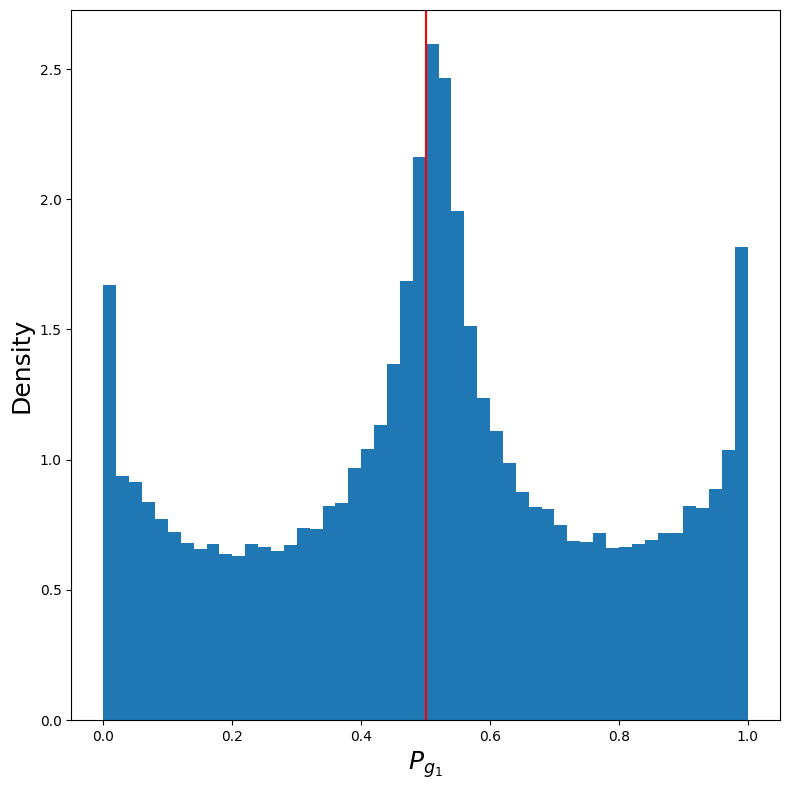

In [15]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

ax.hist(ellipticity1_vsbc[mask & ~ellipticity1_vsbc.isnan()], density=True, bins=50)
ax.axvline(0.5, color="red")
ax.set_ylabel("Density", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("$P_{g_1}$", fontsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "g1_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

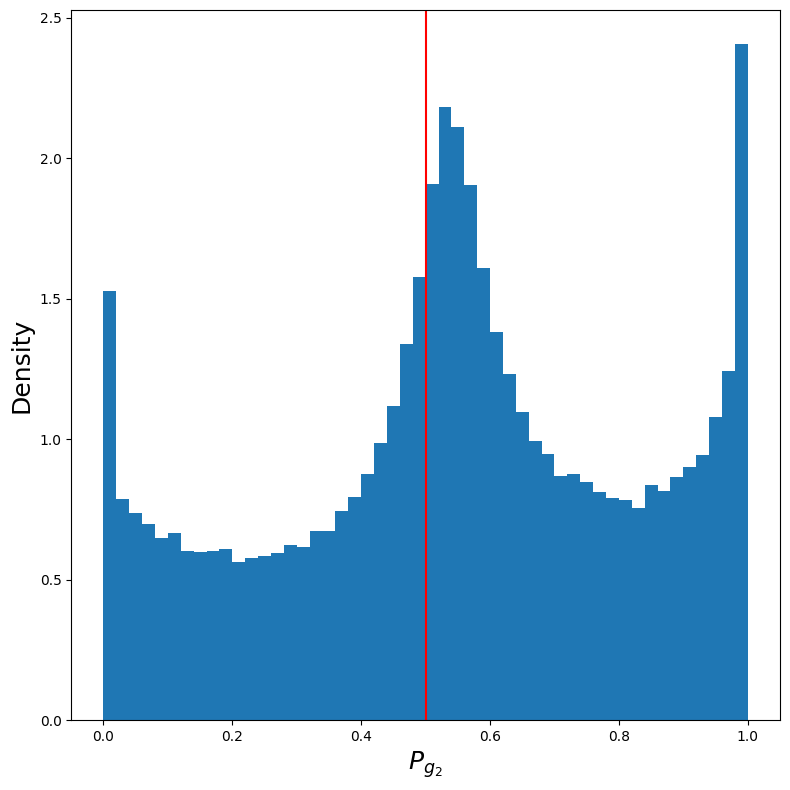

In [16]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

ax.hist(ellipticity2_vsbc[mask & ~ellipticity2_vsbc.isnan()], density=True, bins=50)
ax.axvline(0.5, color="red")
ax.set_ylabel("Density", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("$P_{g_2}$", fontsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "g2_vsbc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()